In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Introduction and Data Analysis


In this notebook, I'm going to build a machine learning model and interpret the model using SHAP. This should unwrap some of the hidden mysteries that happened in the Titanic and help us visualize the effect of the socioeconomic class on the survival rate.



In [2]:
df = pd.read_csv(r'..\..\data\raw\train.csv')
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Dealing with missing values


<AxesSubplot:>

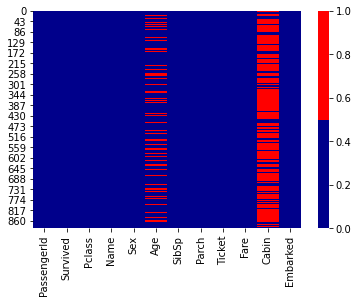

In [3]:
cols = df.columns 
colours = ['darkblue', 'red'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [4]:
top = df["Embarked"].describe()['top'] # impute with the most frequent value.
df["Embarked"] = df["Embarked"].fillna(top)

In [5]:
pct_list = []
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    if round(pct_missing*100) >0:
        pct_list.append([col, round(pct_missing*100)])
    print('{} - {}%'.format(col, round(pct_missing*100)))

PassengerId - 0%
Survived - 0%
Pclass - 0%
Name - 0%
Sex - 0%
Age - 20%
SibSp - 0%
Parch - 0%
Ticket - 0%
Fare - 0%
Cabin - 77%
Embarked - 0%


The feature "Cabin" is missing 77% of the data. So I'm going to remove that feature. Age, however, is missing 20% of the data. Age should be an important variable in this application since it must have affected the probability of survival (e.g. older people or children might have been given the priority). Usually, I would just fill the missing values with the mean of the other's people's age. However, in this specific dataset, people were from different classes so it's not a good idea to treat all of them as one group. The dataset has a feature "Name" the name has the title of the people (e.g. "Mr", "Miss"…etc). That title should be a great indication of the age. Also, I should keep in mind that at that time of the incidence (in 1912) the socioeconomic status affected the people's title regardless on age (e.g. younger people who are rich could get titles that usual poor people at the same age wouldn't). So I'm going to group people by their title and Pclass and then I will assign the mean of the age of each group to the missing age in each group.

In [6]:
# extracting the titles from the names:
Title = []
for name in  df.Name:
    Title.append(name.split(",")[1].split(".")[0])
    
df["Title"] = Title

In [7]:
df.groupby(["Pclass", 'Title'])['Age'].agg(['mean']).round(0)


mean
Pclass Title              
1       Capt          70.0
        Col           58.0
        Don           40.0
        Dr            44.0
        Jonkheer      38.0
        Lady          48.0
        Major         48.0
        Master         5.0
        Miss          30.0
        Mlle          24.0
        Mme           24.0
        Mr            42.0
        Mrs           41.0
        Sir           49.0
        the Countess  33.0
2       Dr            38.0
        Master         2.0
        Miss          22.0
        Mr            33.0
        Mrs           34.0
        Ms            28.0
        Rev           43.0
3       Master         5.0
        Miss          16.0
        Mr            29.0
        Mrs           34.0

In [8]:
# replacing the NAs by the mean age of each group:
df["Age"] = df.groupby(["Title", "Pclass"])["Age"].transform(lambda x: x.fillna(x.median()))
df = df.drop(columns = ["Cabin"])

In [9]:
df = df.drop(columns = ["Name"])
df = df.drop(columns = ["PassengerId"])
df = df.drop(columns = ["Ticket"])

In [10]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


As a final step, I will encode the categorical features into numerical:



In [11]:
df.Sex = pd.Categorical(df.Sex)
df.Embarked = pd.Categorical(df.Embarked)


df["Sex"] = df.Sex.cat.codes
df["Embarked"] = df.Embarked.cat.codes

In [12]:
df = df.drop(columns = ["Title"])
target = df.Survived.values
df = df.drop(columns =["Survived"])

### Building the Linear Model


In [13]:
from sklearn.model_selection import train_test_split


In [14]:
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=0)


In [15]:
from sklearn.linear_model import LogisticRegression


In [16]:
LR = LogisticRegression()
LR.fit(x_train, y_train)

c:\Users\Parth.chokhra\Miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [17]:
LR.score(x_test, y_test)


0.8100558659217877

### Model Interpretation with SHAP
Now, we can get to the fun part. I will use SHAP to interpret that model to see how these features affected the incidence of the Titanic.  SHAP is a great model interpretation tool. Even though it's a sophisticated model, it's intuitive to understand. SHAP's goal is to provide a visualization of the effect of each feature on the outcome variable. To do that, SHAP would build a model that uses all the features except the one in interest and see how the model would do without that feature. Then, it would build the model again and do the prediction with the feature. The effect of the feature would then be the difference between the two values. But the order at which features are passed to the model affects the output (especially in the tree-based models in which the model follows a schematic approach ordered by the features). So SHAP computes all the possible permutation at which the different features can be passed to the model. This seems to have a huge computational cost but SHAP has optimized algorithms that make it faster for specific machine learning models.

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


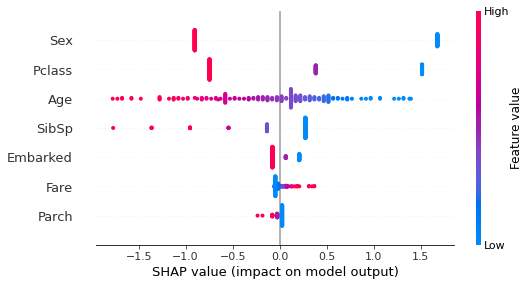

In [18]:
import shap
explainer = shap.LinearExplainer(LR, x_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


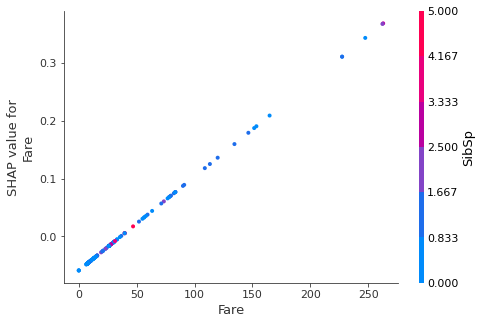

In [19]:
shap.dependence_plot("Fare", shap_values, x_test)

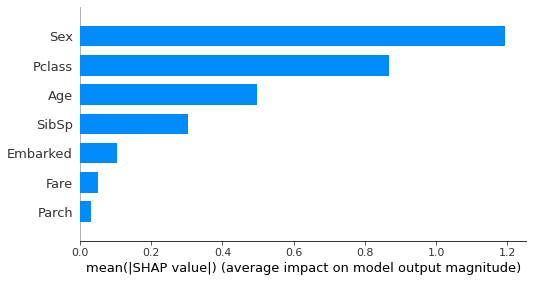

In [20]:
shap.summary_plot(shap_values, x_train, plot_type="bar")


As expected from the statistical inference that I conducted, the Pclass has a significant effect on the survival rate of the passengers. It's the second most significant feature after "Sex". We see from the plot above that low values (blue) for Pclass which correspond to a class of 1 (richer people) have a positive effect on people's survival while higher values (red), which correspond to the third class, have a negative effect on the survival rate. We can also see that "sex" is the most important feature with an indication that being a "female" (blue) had a positive impact on the survival rate. The feature "Age" also shows that lower values (blue) had a positive impact on survival. We see that there is a linear relationship between how much people paid and their chance of survival. The richer they were the more likely they survived.

In [21]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, x_test, link="logit")


In [22]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], x_test.iloc[0,:], link="logit")


In [23]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[3,:], x_test.iloc[3,:], link="logit")


### Conclusion
From the statistical analysis and the model interpretation I conducted, I can make the following induction about what happened at the titanic. When the ship started to sink, rich people had the priority to leave the ship. Those with a fewer number of siblings were faster since they didn't have to look for their family. When they found out that the lifeboats number was limited, they decided to prioritize children and women. So the priority was as the following: rich women and children, rich men, then everyone else. It's very interesting how such insights can be fully extracted from a dataset.